<a href="https://colab.research.google.com/github/Shiva1906/DeepLearning/blob/GAN/GAN/Pix2PixGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Implementation of Pix2Pix GAN**

##Required Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary
import os
from tqdm import tqdm
from PIL import Image

##Config Variables

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
learning_rate = 3e-4
epochs = 10
img_size = 256
img_channels = 3
features = [64,128,256,512]
LAMBDA = 100


In [ ]:
from google.colab import drive
drive.mount('/content/drive1')

In [34]:
!rm -rf content
import shutil
class DatasetHumanSeg(Dataset):
  def __init__(self,root_dir):
    self.root_dir = root_dir
    self.images = []
    self.masks = []
    image_files = os.listdir(os.path.join(root_dir,"images"))
    for files in image_files:
      self.images.append(os.path.join(root_dir,"images",files))
      self.masks.append(os.path.join(root_dir,"masks",files))

    # for i in range(len(self.images)):
    #   images_new = self.images[i].replace(root_dir,"./content")
    #   masks_new = self.masks[i].replace(root_dir,"./content")
    #   os.makedirs(os.path.dirname(images_new),exist_ok=True)
    #   os.makedirs(os.path.dirname(masks_new),exist_ok=True)
    #   shutil.copy(self.images[i],images_new)
    #   shutil.copy(self.masks[i],masks_new)
    self.img_transform = self.img_transform()
    self.mask_transform = self.mask_transform()


  def __len__(self):
    return len(self.images)

  def read(self,index):
    img_path = os.path.join(self.root_dir,"images",self.images[index])
    mask_path = os.path.join(self.root_dir,"masks",self.masks[index])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = mask[:,:,0]
    return image,mask

  def __getitem__(self,index):
    image,mask = self.read(index)
    image = Image.fromarray(image)
    mask = Image.fromarray(mask).convert("L")
    image = self.img_transform(image)
    mask = self.mask_transform(mask)
    return image,mask

  def img_transform(self):
    img_transforms =  transforms.Compose([transforms.Resize((img_size, img_size)),
                                          transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),])
    return img_transforms
  def mask_transform(self):
    mask_transforms = transforms.Compose([transforms.Resize((img_size, img_size)),
                                          transforms.ToTensor(),])
    return mask_transforms

In [35]:
train_data = DatasetHumanSeg(root_dir='/content/drive1/MyDrive/HumanSegmentation')
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

##**Discriminator**

In [36]:
class CNNBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel=4,stride=2,padding=1):
    super(CNNBlock,self).__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel,stride,padding,bias=False,padding_mode="reflect"),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.conv_block(x)

class Discriminator(nn.Module):
  def __init__(self,in_channels=3,features=[64,128,256,512]):
    super(Discriminator,self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels+1,features[0],kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
        nn.LeakyReLU(0.2)
    )
    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(
          CNNBlock(in_channels,feature,stride=1 if feature==features[-1] else 2)
      )
      in_channels = feature
    layers.append(
        nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
    )
    self.model = nn.Sequential(*layers)
  def forward(self,x,y):
    x = torch.cat([x,y],dim=1)
    x = self.initial(x)
    x = self.model(x)
    return x

##**Generator**

In [37]:
class CNNBlock1(nn.Module):
  def __init__(self,in_channels,out_channels,kernel=4,stride=2,padding=1,down=True):
    super(CNNBlock1,self).__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel,stride,padding,bias=False,padding_mode="reflect")
        if down
        else nn.ConvTranspose2d(in_channels,out_channels,kernel,stride,padding,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self,x):
      return self.conv_block(x)
## U-Net
class Generator(nn.Module):
  def __init__(self,in_channels=3,features=64):
    super(Generator,self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,features,kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
        nn.ReLU()
    )
    self.down1 = CNNBlock1(features,features*2,down=True)
    self.down2 = CNNBlock1(features*2,features*4,down=True)
    self.down3 = CNNBlock1(features*4,features*8,down=True)
    self.down4 = CNNBlock1(features*8,features*8,down=True)
    self.down5 = CNNBlock1(features*8,features*8,down=True)
    self.down6 = CNNBlock1(features*8,features*8,down=True)

    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8,features*8,kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
        nn.ReLU()
    )
    self.up1 = CNNBlock1(features*8,features*8,down=False)
    self.up2 = CNNBlock1(features*8*2,features*8,down=False)
    self.up3 = CNNBlock1(features*8*2,features*8,down=False)
    self.up4 = CNNBlock1(features*8*2,features*8,down=False)
    self.up5 = CNNBlock1(features*8*2,features*4,down=False)
    self.up6 = CNNBlock1(features*4*2,features*2,down=False)
    self.up7 = CNNBlock1(features*2*2,features,down=False)

    self.final = nn.Sequential(
        nn.ConvTranspose2d(features*2,1,kernel_size=4,stride=2,padding=1),
        nn.Tanh()
    )
  def forward(self,x):
    d1 = self.initial(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)
    bottleneck = self.bottleneck(d7)
    up1 = self.up1(bottleneck)
    up2 = self.up2(torch.cat([up1,d7],dim=1))
    up3 = self.up3(torch.cat([up2,d6],dim=1))
    up4 = self.up4(torch.cat([up3,d5],dim=1))
    up5 = self.up5(torch.cat([up4,d4],dim=1))
    up6 = self.up6(torch.cat([up5,d3],dim=1))
    up7 = self.up7(torch.cat([up6,d2],dim=1))
    return self.final(torch.cat([up7,d1],dim=1))


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [0/10] Batch 0/42           Loss D: 1.4372, loss G: 75.5811


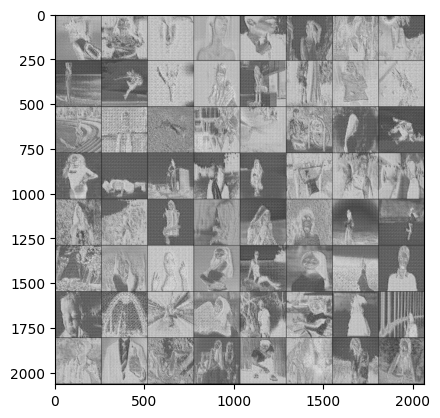

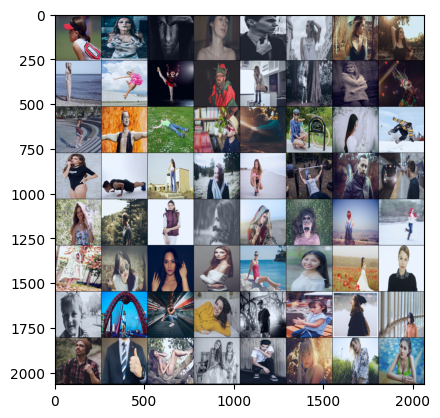

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/10] Batch 0/42           Loss D: 1.3978, loss G: 29.8122


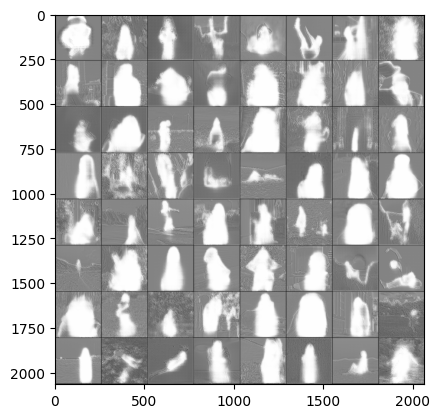

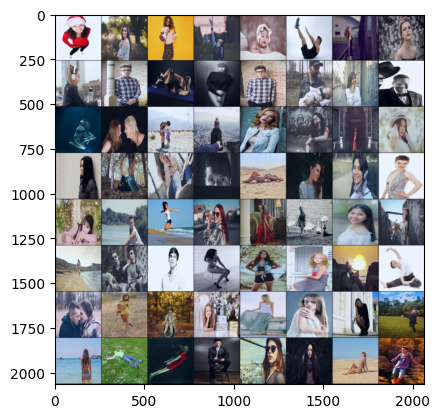

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/10] Batch 0/42           Loss D: 1.4556, loss G: 25.5843


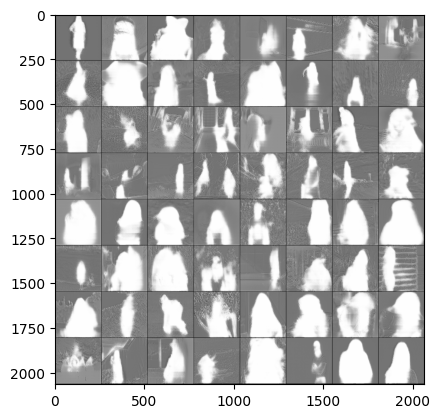

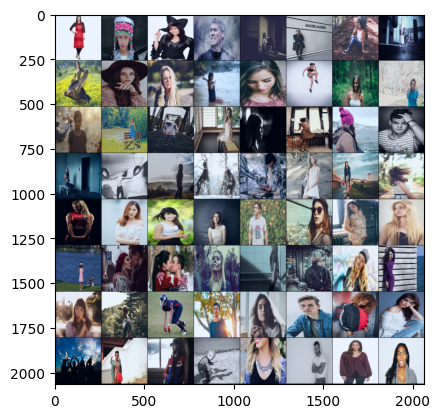

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/10] Batch 0/42           Loss D: 1.3724, loss G: 25.2082


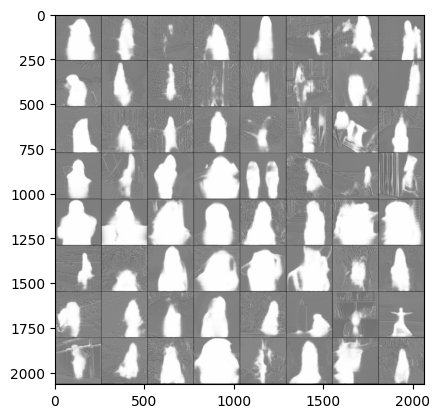

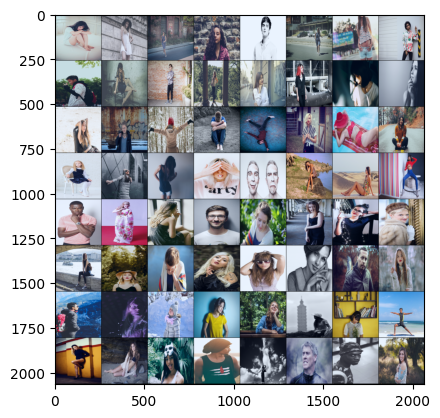

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/10] Batch 0/42           Loss D: 1.3631, loss G: 18.8305


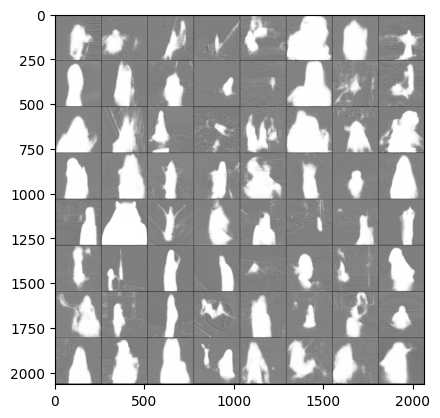

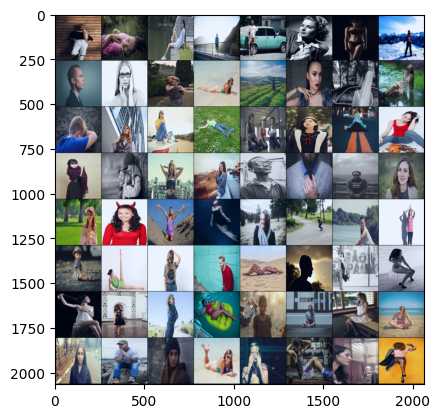

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/10] Batch 0/42           Loss D: 1.0213, loss G: 19.1483


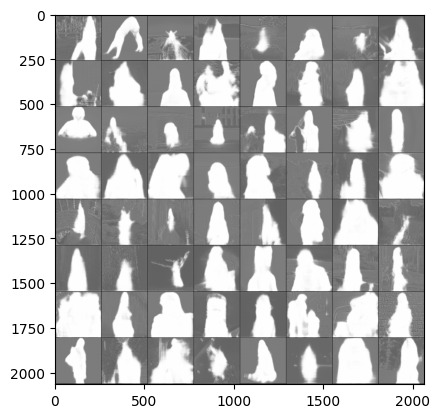

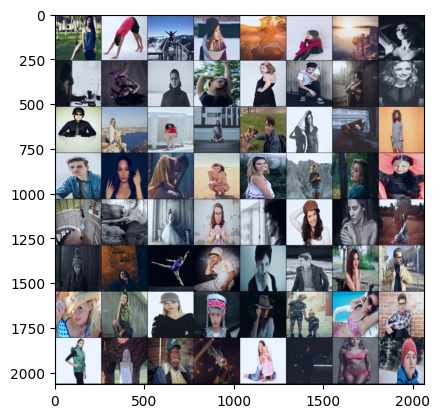

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/10] Batch 0/42           Loss D: 1.2984, loss G: 17.8095


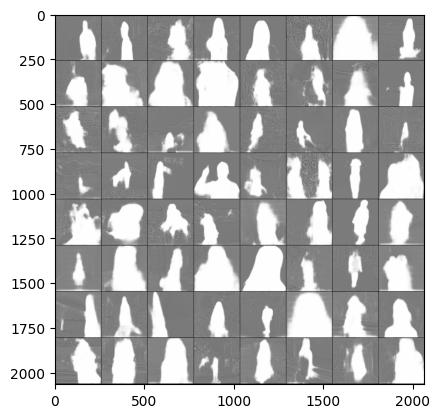

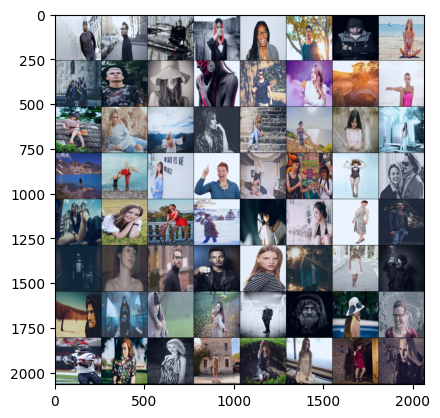

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/10] Batch 0/42           Loss D: 1.3189, loss G: 17.1901


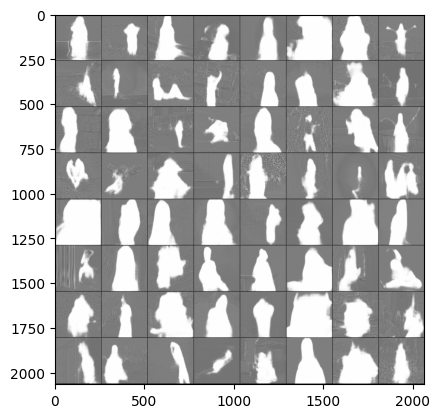

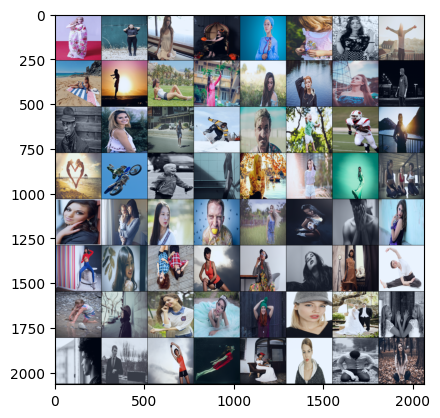

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/10] Batch 0/42           Loss D: 1.3539, loss G: 15.5752


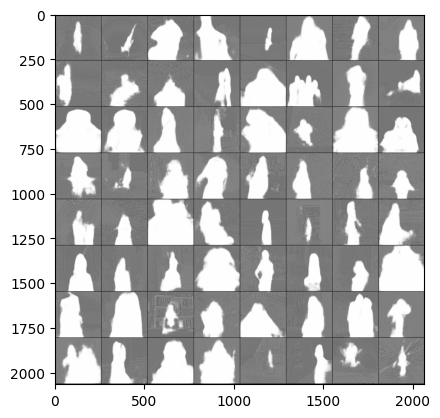

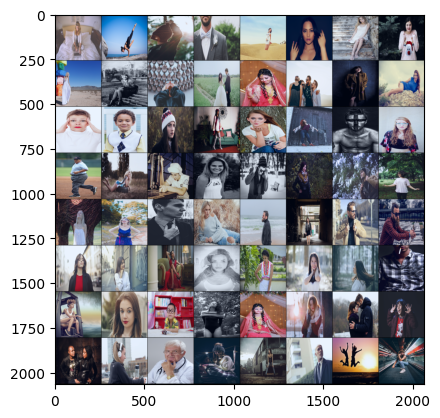

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/10] Batch 0/42           Loss D: 1.5566, loss G: 14.5744


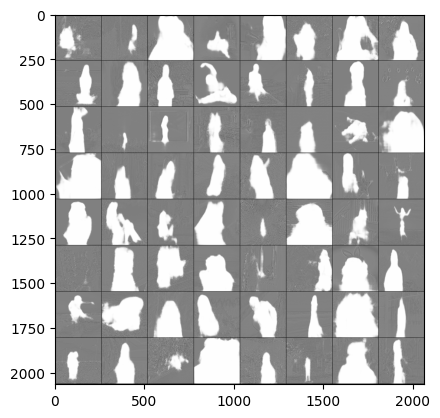

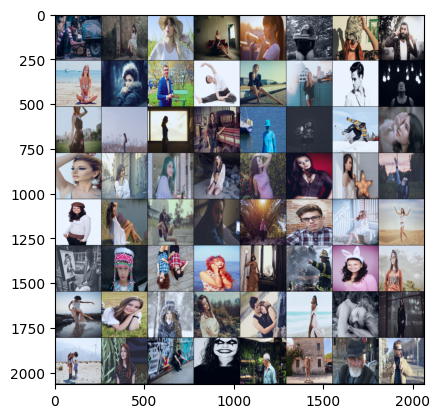

100%|██████████| 42/42 [04:08<00:00,  5.93s/it]


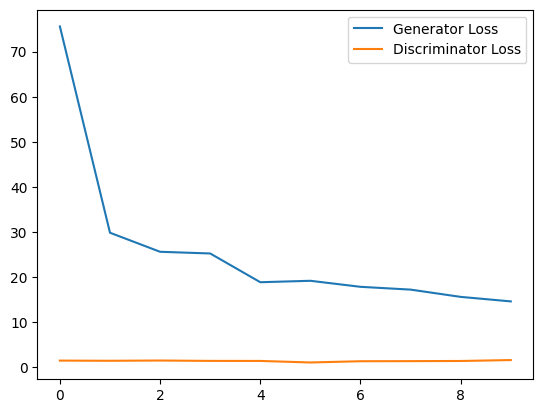

In [41]:

gen = Generator().to(device)
disc = Discriminator().to(device)
loss = nn.BCEWithLogitsLoss()
loss2 = nn.L1Loss()

opt_gen = torch.optim.Adam(gen.parameters(),lr=learning_rate,betas=(0.2,0.999))
opt_disc = torch.optim.Adam(disc.parameters(),lr=learning_rate,betas=(0.2,0.999))


disc.train()
gen.train()

losses_g = []
losses_d = []

for epoch in range(0,epochs):
  for batch_idx,(real,mask) in enumerate(tqdm(train_dataloader)):
    real = real.to(device)
    mask = mask.to(device)
    fake_mask = gen(real)
    dis_real = disc(real,mask)
    dis_fake = disc(real,fake_mask.detach())
    lossD = loss(dis_real,torch.ones_like(dis_real)) + loss(dis_fake,torch.zeros_like(dis_fake))
    disc.zero_grad()
    lossD.backward()
    opt_disc.step()

    output = disc(real,fake_mask)
    lossG = loss(output,torch.ones_like(output)) + LAMBDA*loss2(fake_mask,mask)
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_idx == 0:
      print(
          f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_dataloader)} \
          Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
      )
      losses_g.append(lossG.item())
      losses_d.append(lossD.item())

      with torch.no_grad():
        fake = gen(real.to(device))
        img_grid_fake = torchvision.utils.make_grid(fake,normalize=True)
        img_grid_real = torchvision.utils.make_grid(real,normalize=True)
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1,2,0))
        plt.show()
        plt.imshow(img_grid_real.cpu().detach().numpy().transpose(1,2,0))
        plt.show()
plt.plot(losses_g,label="Generator Loss")
plt.plot(losses_d,label="Discriminator Loss")
plt.legend()
plt.show()

In [45]:
torch.save(gen,"gen.pth")
torch.save(disc,"disc.pth")